In [4]:
import Pkg; Pkg.add("JSON"); Pkg.add("Plots")

using JSON
using Plots

    Updating registry at `C:\Users\flama\.julia\registries\General.toml`


   Resolving package versions...


  No Changes to `C:\Users\flama\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\flama\.julia\environments\v1.8\Manifest.toml`


   Resolving package versions...


  No Changes to `C:\Users\flama\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\flama\.julia\environments\v1.8\Manifest.toml`


In [5]:
json_tiny = JSON.parsefile("KIRO-tiny.json")


Dict{String, Any} with 7 entries:
  "land_substation_cable_types"       => Any[Dict{String, Any}("rating"=>500, "…
  "wind_turbines"                     => Any[Dict{String, Any}("id"=>1, "x"=>-5…
  "wind_scenarios"                    => Any[Dict{String, Any}("power_generatio…
  "substation_locations"              => Any[Dict{String, Any}("id"=>1, "x"=>-1…
  "substation_types"                  => Any[Dict{String, Any}("cost"=>100000, …
  "general_parameters"                => Dict{String, Any}("maximum_power"=>100…
  "substation_substation_cable_types" => Any[Dict{String, Any}("rating"=>500, "…

In [6]:
json_small = JSON.parsefile("KIRO-small.json")

Dict{String, Any} with 7 entries:
  "land_substation_cable_types"       => Any[Dict{String, Any}("rating"=>200, "…
  "wind_turbines"                     => Any[Dict{String, Any}("id"=>1, "x"=>79…
  "wind_scenarios"                    => Any[Dict{String, Any}("power_generatio…
  "substation_locations"              => Any[Dict{String, Any}("id"=>1, "x"=>35…
  "substation_types"                  => Any[Dict{String, Any}("cost"=>300.0, "…
  "general_parameters"                => Dict{String, Any}("maximum_curtailing"…
  "substation_substation_cable_types" => Any[Dict{String, Any}("rating"=>100, "…

In [7]:
json_medium = JSON.parsefile("KIRO-medium.json")

Dict{String, Any} with 7 entries:
  "land_substation_cable_types"       => Any[Dict{String, Any}("rating"=>200, "…
  "wind_turbines"                     => Any[Dict{String, Any}("id"=>1, "x"=>78…
  "wind_scenarios"                    => Any[Dict{String, Any}("power_generatio…
  "substation_locations"              => Any[Dict{String, Any}("id"=>1, "x"=>40…
  "substation_types"                  => Any[Dict{String, Any}("cost"=>300.0, "…
  "general_parameters"                => Dict{String, Any}("maximum_curtailing"…
  "substation_substation_cable_types" => Any[Dict{String, Any}("rating"=>100, "…

In [8]:
json_large = JSON.parsefile("KIRO-large.json")

Dict{String, Any} with 7 entries:
  "land_substation_cable_types"       => Any[Dict{String, Any}("rating"=>200, "…
  "wind_turbines"                     => Any[Dict{String, Any}("id"=>1, "x"=>78…
  "wind_scenarios"                    => Any[Dict{String, Any}("power_generatio…
  "substation_locations"              => Any[Dict{String, Any}("id"=>1, "x"=>65…
  "substation_types"                  => Any[Dict{String, Any}("cost"=>240.0, "…
  "general_parameters"                => Dict{String, Any}("maximum_curtailing"…
  "substation_substation_cable_types" => Any[Dict{String, Any}("rating"=>100, "…

In [9]:
json_huge = JSON.parsefile("KIRO-huge.json")

Dict{String, Any} with 7 entries:
  "land_substation_cable_types"       => Any[Dict{String, Any}("rating"=>200, "…
  "wind_turbines"                     => Any[Dict{String, Any}("id"=>1, "x"=>79…
  "wind_scenarios"                    => Any[Dict{String, Any}("power_generatio…
  "substation_locations"              => Any[Dict{String, Any}("id"=>1, "x"=>22…
  "substation_types"                  => Any[Dict{String, Any}("cost"=>240.0, "…
  "general_parameters"                => Dict{String, Any}("maximum_curtailing"…
  "substation_substation_cable_types" => Any[Dict{String, Any}("rating"=>100, "…

In [10]:
# Get Functions

function get_parameters(name_json)
    general_parameters = name_json["general_parameters"]
    return general_parameters
end

function get_wind_turbines(name_json)
    get_wind_turbines = name_json["wind_turbines"]

    return get_wind_turbines
end

function get_wind_scenarios(name_json)
    get_wind_scenarios = name_json["wind_scenarios"]
    return get_wind_scenarios
end

function get_substation_locations(name_json)
    get_substation_locations = name_json["substation_locations"]
    
    return get_substation_locations
end

function get_substation_types(name_json)
    get_substation_types = name_json["substation_types"]

    return get_substation_types
end

function get_land_substation_cable_types(name_json)
    get_land_substation_cable_types = name_json["land_substation_cable_types"]

    return get_land_substation_cable_types
end

function get_substation_substation_cable_types(name_json)
    get_substation_substation_cable_types = name_json["substation_substation_cable_types"]

    return get_substation_substation_cable_types
end

get_substation_substation_cable_types (generic function with 1 method)

In [11]:
#collectes des données utiles

file = json_small

P_max = get_parameters(file)["maximum_power"]
coords_mls = get_parameters(file)["main_land_station"]
C_ft = get_parameters(file)["fixed_cost_cable"]
C_lt = get_parameters(file)["variable_cost_cable"]
C_0 = get_parameters(file)["curtailing_cost"]
C_p = get_parameters(file)["curtailing_penalty"]
C_max = get_parameters(file)["maximum_curtailing"]
general_parameters = Dict("maximum_power" => P_max, "main_land_station" => coords_mls, "fixed_cost_cable" => C_ft, "variable_cost_cable" => C_lt, "curtailing_cost" => C_0, "curtailing_penalty" => C_p, "maximum_curtailing" => C_max)

v_0 = [coords_mls["x"], coords_mls["y"]]

print(v_0)

wind_turbines = get_wind_turbines(file)
x_turbines = [turbine["x"] for turbine in wind_turbines]
y_turbines = [turbine["y"] for turbine in wind_turbines]

V_t = []
for i in 1:length(x_turbines)
    push!(V_t,[x_turbines[i], y_turbines[i]])
end

print(V_t)

wind_scenarios = get_wind_scenarios(file)

substation_locations = get_substation_locations(file)
x_substations = [substation["x"] for substation in substation_locations]
y_substations = [substation["y"] for substation in substation_locations]

V_s = []
for i in 1:length(x_substations)
    push!(V_s, [x_substations[i], y_substations[i]])
end

print(length(V_s))

substation_types = get_substation_types(file)

land_substation_cable_types = get_land_substation_cable_types(file)

sub_sub_cable_types = get_substation_substation_cable_types(file)


[0, 0]

Any[

[79.0, -3.5], [79.5, -3.5], [80.0, -3.5], [80.5, -3.5], [81.0, -3.5], [79.0, -3.0], [79.5, -3.0], [80.0, -3.0], [80.5, -3.0], [81.0, -3.0], [79.0, -2.5], [79.5, -2.5], [80.0, -2.5], [80.5, -2.5], [81.0, -2.5], [79.0, -2.0], [79.5, -2.0], [80.0, -2.0], [80.5, -2.0], [81.0, -2.0], [79.0, -1.5], [79.5, -1.5], [80.0, -1.5], [80.5, -1.5], [81.0, -1.5], [79.0, -1.0], [79.5, -1.0], [80.0, -1.0], [80.5, -1.0], [81.0, -1.0], [79.0, -0.5], [79.5, -0.5], [80.0, -0.5], [80.5, -0.5], [81.0, -0.5], [79.0, 0.0], [79.5, 0.0], [80.0, 0.0], [80.5, 0.0], [81.0, 0.0], [79.0, 0.5], [79.5, 0.5], [80.0, 0.5], [80.5, 0.5], [81.0, 0.5], [79.0, 1.0], [79.5, 1.0], [80.0, 1.0], [80.5, 1.0], [81.0, 1.0], [79.0, 1.5], [79.5, 1.5], [80.0, 1.5], [80.5, 1.5], [81.0, 1.5], [79.0, 2.0], [79.5, 2.0], [80.0, 2.0], [80.5, 2.0], [81.0, 2.0], [79.0, 2.5], [79.5, 2.5], [80.0, 2.5], [80.5, 2.5], [81.0, 2.5], [79.0, 3.0], [79.5, 3.0], [80.0, 3.0], [80.5, 3.0], [81.0, 3.0], [79.0, 3.5], [79.5, 3.5], [80.0, 3.5], [80.5, 3.5], [81

15

18-element Vector{Any}:
 Dict{String, Any}("rating" => 100, "variable_cost" => 1.0, "id" => 1, "fixed_cost" => 40.0)
 Dict{String, Any}("rating" => 200, "variable_cost" => 2.0, "id" => 2, "fixed_cost" => 40.0)
 Dict{String, Any}("rating" => 300, "variable_cost" => 3.0, "id" => 3, "fixed_cost" => 40.0)
 Dict{String, Any}("rating" => 500, "variable_cost" => 5.0, "id" => 4, "fixed_cost" => 50.0)
 Dict{String, Any}("rating" => 900, "variable_cost" => 9.0, "id" => 5, "fixed_cost" => 50.0)
 Dict{String, Any}("rating" => 1450, "variable_cost" => 14.0, "id" => 6, "fixed_cost" => 60.0)
 Dict{String, Any}("rating" => 100, "variable_cost" => 0.9, "id" => 7, "fixed_cost" => 36.0)
 Dict{String, Any}("rating" => 200, "variable_cost" => 1.8, "id" => 8, "fixed_cost" => 36.0)
 Dict{String, Any}("rating" => 300, "variable_cost" => 2.7, "id" => 9, "fixed_cost" => 36.0)
 Dict{String, Any}("rating" => 500, "variable_cost" => 4.5, "id" => 10, "fixed_cost" => 45.0)
 Dict{String, Any}("rating" => 900, "variab

In [12]:
# Fonctions coûts 

function cost_turbines_substation(L, D1, general_parameters)
    # L : vecteur liant turbines et sous-stations
    # D1 : matrice des distances entre les turbines et les sous-stations
    # general_parameters : paramètres généraux du problème

    # On initialise le coût
    cost = 0

    # On calcule le coût de la liaison entre les turbines et les sous-stations
    for i in 1:length(L)
        cost += general_parameters["fixed_cost_cable"] +D1[i,L[i]]*general_parameters["variable_cost_cable"]
    end

    return cost
end

function cost_substation_substation(S, D2, substation_substation_cable_types)
    # S : vecteur liant les sous-stations
    # D2 : matrice des distances entre les sous-stations
    # substation_substation_cable_types : types de câbles entre les sous-stations

    # On initialise le coût
    cost = 0

    # On calcule le coût de la liaison entre les sous-stations
    for i in 1:size(S, 1)
        if S[i, 2] != 0 && S[i, 4] != 0
            cost += substation_substation_cable_types[S[i, 4]]["fixed_cost"]+D2[i, S[i, 2]]*substation_substation_cable_types[S[i, 4]]["variable_cost"]
        end
    end
    cost = cost/2

    return cost
end

function cost_substation_land_substation(S, D3, land_substation_cable_types)
    # S : vecteur liant les sous-stations
    # D3 : vecteur des distances entre les sous-stations et la station terrestre
    # land_substation_cable_types : types de câbles entre les sous-stations et la station terrestre

    # On initialise le coût
    cost = 0

    # On calcule le coût de la liaison entre les sous-stations et la station terrestre
    for i in 1:size(S, 1)
        if S[i, 3] != 0
            cost += land_substation_cable_types[S[i, 3]]["fixed_cost"]+D3[i]*land_substation_cable_types[S[i, 3]]["variable_cost"]
        end
    end

    return cost
end

function cost_substation(S, substation_types)
    # S : vecteur liant les sous-stations
    # substation_types : types de sous-stations

    # On initialise le coût
    cost = 0

    # On calcule le coût de construction des sous-stations
    for i in 1:size(S, 1)
        if S[i, 5] != 0
            cost += substation_types[S[i, 5]]["cost"]
        end
    end

    return cost
end


function c_c(C, general_parameters)

    return general_parameters["curtailing_cost"]*C + general_parameters["curtailing_penalty"]*max(0,C-general_parameters["maximum_curtailing"])
end


function C_f_aux(v, v1, w, wind_scenarios, S, substation_substation_cable_types, land_substation_cable_types, substation_types)
    C_f_aux = 0

    C_f_aux += wind_scenarios[w]["power_generation"]*S[v1, 1]

    if S[v1, 2] == v && S[v1, 4] != 0
        C_f_aux += min(substation_substation_cable_types[S[v1, 4]]["rating"], wind_scenarios[w]["power_generation"]*S[v, 1])
    else
        C_f_aux += min(0, wind_scenarios[w]["power_generation"]*S[v, 1])
    end

    if S[v1, 3] != 0
        C_f_aux -= min(substation_types[S[v1, 5]]["rating"],land_substation_cable_types[S[v1, 3]]["rating"])
    end

    return C_f_aux
end


function C_f(v, w, wind_scenarios, S, substation_substation_cable_types, land_substation_cable_types, substation_types)
    C_f = 0

    if S[v, 2] != 0 && S[v, 4] != 0
        C_f += max(0, wind_scenarios[w]["power_generation"]*S[v, 1]-substation_substation_cable_types[S[v, 4]]["rating"])
    else
        C_f += max(0, wind_scenarios[w]["power_generation"]*S[v, 1])
    end

    for i in 1:size(S, 1)
        if S[i, 3] != 0
            C_f += max(0, C_f_aux(v, i, w, wind_scenarios, S, substation_substation_cable_types, land_substation_cable_types, substation_types))
        end
    end

    return C_f

end


function C_n(w, wind_scenarios, S, substation_substation_cable_types, land_substation_cable_types, substation_types)
    
    C_n = 0

    for i in 1:size(S, 1)
        if S[i, 3] != 0
            C_n += max(0, wind_scenarios[w]["power_generation"]*S[i, 1]-min(substation_types[S[i, 5]]["rating"],land_substation_cable_types[S[i, 3]]["rating"]))
        end
    end

    return C_n
end
    

function p_f(v, S, land_substation_cable_types, substation_types)
    p_f = 0

    if S[v, 3] != 0
        p_f += land_substation_cable_types[S[v, 3]]["probability_of_failure"]

        p_f += substation_types[S[v, 5]]["probability_of_failure"]
    end

    return p_f
end


function operational_cost_aux(S, w, wind_scenarios, general_parameters, substation_substation_cable_types, land_substation_cable_types, substation_types)
    cost1 = 0
    cost2 = 0

    for i in 1:size(S, 1)
        cost1 += p_f(i, S, land_substation_cable_types, substation_types)*c_c(C_f(i, w, wind_scenarios, S, substation_substation_cable_types, land_substation_cable_types, substation_types), general_parameters)
    end

    for i in 1:size(S, 1)
        cost2 += p_f(i, S, land_substation_cable_types, substation_types)
    end
    cost2 = (1 - cost2)*c_c(C_n(w, wind_scenarios, S, substation_substation_cable_types, land_substation_cable_types, substation_types),general_parameters)

    return cost1 + cost2
end

function operational_cost(L, S, wind_scenarios, general_parameters, substation_substation_cable_types, land_substation_cable_types, substation_types)
    # L : vecteur liant turbines et sous-stations
    # S : vecteur liant les sous-stations
    # wind_scenarios : scénarios de vent
    # general_parameters : paramètres généraux du problème

    # On initialise le coût
    cost = 0

    for w in 1:length(wind_scenarios)
        cost += wind_scenarios[w]["probability"]*operational_cost_aux(S, w, wind_scenarios, general_parameters, substation_substation_cable_types, land_substation_cable_types, substation_types)
        
    end

    return cost
end

function cost(L, S, D1, D2, D3, wind_scenarios, general_parameters, substation_substation_cable_types, land_substation_cable_types, substation_types)
    # L : vecteur liant turbines et sous-stations
    # S : vecteur liant les sous-stations
    # D1 : matrice des distances entre les turbines et les sous-stations
    # D2 : matrice des distances entre les sous-stations
    # D3 : vecteur des distances entre les sous-stations et la station terrestre
    # wind_scenarios : scénarios de vent
    # general_parameters : paramètres généraux du problème
    # substation_substation_cable_types : types de câbles entre les sous-stations
    # land_substation_cable_types : types de câbles entre les sous-stations et la station terrestre
    # substation_types : types de sous-stations

    # On initialise le coût
    cost = 0

    # On calcule le coût de la liaison entre les turbines et les sous-stations
    cost += cost_turbines_substation(L, D1, general_parameters)

    # On calcule le coût de la liaison entre les sous-stations
    cost += cost_substation_substation(S, D2, substation_substation_cable_types)

    # On calcule le coût de la liaison entre les sous-stations et la station terrestre
    cost += cost_substation_land_substation(S, D3, land_substation_cable_types)

    # On calcule le coût de construction des sous-stations
    cost += cost_substation(S, substation_types)

    # On calcule le coût opérationnel
    cost += operational_cost(L, S, wind_scenarios, general_parameters, substation_substation_cable_types, land_substation_cable_types, substation_types)

    return cost
end

cost (generic function with 1 method)

In [13]:
#  Création des matrices de distances des turbines aux sous-stations, des sous-stations à la station terrestre et des sous-stations entre elles

function distance(V_t,V_s,v_0)
    # V_t : vecteur des turbines
    # V_s : vecteur des sous-stations
    # v_0 : vecteur de la station terrestre
    
    # On initialise le vecteur des distances
    D1 = zeros(length(V_t),length(V_s))
    D2 = zeros(length(V_s),length(V_s))
    D3 = zeros(length(V_s),1)

    # On calcule les distances entre les turbines et les sous-stations, et entre les sous-stations et la station terrestre et entre les sous-stations
    for i in 1:length(V_t)
        for j in 1:length(V_s)
            D1[i,j] = sqrt((V_t[i][1]-V_s[j][1])^2 + (V_t[i][2]-V_s[j][2])^2)
        end
    end

    for i in 1:length(V_s)
        for j in 1:length(V_s)
            D2[i,j] = sqrt((V_s[i][1]-V_s[j][1])^2 + (V_s[i][2]-V_s[j][2])^2)
        end
        D2[i,i] = +Inf
    end

    for i in 1:length(V_s)
        D3[i] = sqrt((V_s[i][1]-v_0[1])^2 + (V_s[i][2]-v_0[2])^2)
    end

    return D1,D2,D3
end

distance (generic function with 1 method)

In [14]:
function heuristique_1(D1, D2)
    # D1 : matrice des distances entre les turbines et les sous-stations
    # D2 : matrice des distances entre les sous-stations

    # On initialise le vecteur liant turbines et sous-stations
    L = zeros(Int, size(D1, 1), 1)

    # On initialise le vecteur des sous-stations
    S = zeros(Int, size(D2, 1), 5)

    # On emplit ce vecteur en associant à chaque turbine la sous-station la plus proche
    for i in 1:size(D1, 1)
        L[i] = argmin(D1[i,:])
        S[L[i], 1] += 1
        S[L[i], 5] = 1
        S[L[i], 3] = 1
    end

    # On emplit ce vecteur en associant à chaque sous-station présente dans L la sous-station la plus proche
    for i in 1:length(L)
        if S[L[i], 2] == 0 && S[argmin(D2[L[i],:]), 2] == 0
            S[L[i], 2] = argmin(D2[L[i],:])
            S[S[L[i], 2], 2] = L[i]
            S[L[i], 4] = 1  
            S[S[L[i], 2], 4] = 1
        end
    end

    return L,S
end

heuristique_1 (generic function with 1 method)

In [15]:
# on teste l'heuristique 1

D1, D2, D3 = distance(V_t, V_s, v_0)
L,S = heuristique_1(D1, D2)

cost(L, S, D1, D2, D3, wind_scenarios, general_parameters, sub_sub_cable_types, land_substation_cable_types, substation_types)

5401.482138858938

In [16]:
# Fonctions voisinages
# Ces fonctions sont la base de la méta-heuristique ; elles effectuent les changements de lien entre turbines et sous-stations et entre sous-stations entre elles

function voisinage_turbine_substation(L, S, D1, D2, D3, wind_scenarios, general_parameters, substation_substation_cable_types, land_substation_cable_types, substation_types)
    # L : vecteur liant turbines et sous-stations
    # S : vecteur liant les sous-stations
    # D1 : matrice des distances entre les turbines et les sous-stations
    # D2 : matrice des distances entre les sous-stations
    # D3 : vecteur des distances entre les sous-stations et la station terrestre

    # On choisit aléatoirement une turbine, notée n, on la lie avec la sous-station la plus proche de celle à laquelle est elle actuellement associée
    new = rand(1:length(L))

    S1 = copy(S)
    L1 = copy(L)
    
    old = L[new]
    linked_old = S[old, 2]

    # On change la liaison entre la turbine et la sous-station en choisissant la sous-station la plus proche de l'ancienne sous-station
    #L[new] = argmin(D2[old,:])
    L[new] = rand(1:size(S, 1))
    S[old, 1] -= 1

    # Si la sous-station n'est plus reliée à aucune turbine, on la supprime
    if S[old, 1] == 0
        if linked_old != 0
            if S[L[new], 2] == 0
                S[L[new], 2] = linked_old
                S[linked_old, 2] = L[new]
                S[L[new], 4] = S[linked_old, 4]
            else
                S[linked_old, 2] = 0
                S[linked_old, 4] = 0
            end
        end
        S[old, 2] = 0
        S[old, 3] = 0
        S[old, 4] = 0
        S[old, 5] = 0
    end

    if S[L[new], 1] == 0
        S[L[new], 5] = substation_types[end]["id"]
        S[L[new], 3] = land_substation_cable_types[end]["id"]
    end

    S[L[new], 1] += 1

    if cost(L, S, D1, D2, D3, wind_scenarios, general_parameters, substation_substation_cable_types, land_substation_cable_types, substation_types) < cost(L1, S1, D1, D2, D3, wind_scenarios, general_parameters, substation_substation_cable_types, land_substation_cable_types, substation_types)
        return L, S
    else
        return L1, S1
    end
end

function voisinage_type_cables(L, S, D1, D2, D3, wind_scenarios, general_parameters, substation_substation_cable_types, land_substation_cable_types, substation_types)
    # L : vecteur liant turbines et sous-stations
    # S : vecteur liant les sous-stations
    # D1 : matrice des distances entre les turbines et les sous-stations
    # D2 : matrice des distances entre les sous-stations
    # D3 : vecteur des distances entre les sous-stations et la station terrestre

    # On choisit aléatoirement une sous-station créée, on modifie le type de câble entre cette sous-station et la station terrestre
    S1 = copy(S)
    L1 = copy(L)
    turbine = rand(1:length(L))

    substation = L[turbine]

    new = rand(1:length(land_substation_cable_types))
    S[substation, 3] = land_substation_cable_types[new]["id"]

    if cost(L, S, D1, D2, D3, wind_scenarios, general_parameters, substation_substation_cable_types, land_substation_cable_types, substation_types) < cost(L1, S1, D1, D2, D3, wind_scenarios, general_parameters, substation_substation_cable_types, land_substation_cable_types, substation_types)
        return L, S
    else
        return L1, S1
    end
end

function voisinage_type_substation(L, S, D1, D2, D3, wind_scenarios, general_parameters, substation_substation_cable_types, land_substation_cable_types, substation_types)
    # L : vecteur liant turbines et sous-stations
    # S : vecteur liant les sous-stations
    # D1 : matrice des distances entre les turbines et les sous-stations
    # D2 : matrice des distances entre les sous-stations
    # D3 : vecteur des distances entre les sous-stations et la station terrestre

    # On choisit aléatoirement une sous-station créée, on modifie le type de sous-station
    S1 = copy(S)
    L1 = copy(L)
    turbine = rand(1:length(L))

    substation = L[turbine]

    new = rand(1:length(substation_types))
    S[substation, 5] = substation_types[new]["id"]

    if cost(L, S, D1, D2, D3, wind_scenarios, general_parameters, substation_substation_cable_types, land_substation_cable_types, substation_types) < cost(L1, S1, D1, D2, D3, wind_scenarios, general_parameters, substation_substation_cable_types, land_substation_cable_types, substation_types)
        return L, S
    else
        return L1, S1
    end
end

    

function voisinage_substation_substation(L, S, D1, D2, D3, wind_scenarios, general_parameters, substation_substation_cable_types, land_substation_cable_types, substation_types)
    # L : vecteur liant turbines et sous-stations
    # S : vecteur liant les sous-stations
    # D1 : matrice des distances entre les turbines et les sous-stations
    # D2 : matrice des distances entre les sous-stations
    # D3 : vecteur des distances entre les sous-stations et la station terrestre

    # On choisit aléatoirement une sous-station, notée n, on la lie avec la sous-station la plus proche de celle à laquelle est elle actuellement associée
    
    L1 = copy(L)  # Use copy to create an independent copy of L
    S1 = copy(S)  # Use copy to create an independent copy of S
    substation = rand(1:size(S, 1))

    old = S[substation, 2]

    # Check if the substation is currently linked to a turbine
    if old != 0
        # Find the new substation linked to the nearest turbine (excluding the current substation)
        new = L[argmin(D2[old, filter(x -> x != substation, L)])]

        # Update connections based on the new assignment
        if S[new, 2] != 0
            S[S[new, 2], 2] = old
            S[S[new, 2], 4] = S[old, 4]
            S[old, 2] = S[new, 2]
        else
            S[old, 4] = 0
            S[old, 2] = 0
        end

        S[new, 2] = substation
        S[substation, 2] = new

        S[new, 4] = substation_substation_cable_types[end]["id"]
        S[substation, 4] = substation_substation_cable_types[end]["id"]
    else
        # Find the new substation linked to the nearest turbine
        new = L[argmin(D2[substation, L])]

        # Update connections based on the new assignment
        if S[new, 2] != 0
            S[S[new, 2], 4] = 0
            S[S[new, 2], 2] = 0
        end

        S[substation, 2] = new
        S[new, 2] = substation
        S[substation, 4] = substation_substation_cable_types[end]["id"]
        S[new, 4] = substation_substation_cable_types[end]["id"]
    end

    if cost(L, S, D1, D2, D3, wind_scenarios, general_parameters, substation_substation_cable_types, land_substation_cable_types, substation_types) > cost(L1, S1, D1, D2, D3, wind_scenarios, general_parameters, substation_substation_cable_types, land_substation_cable_types, substation_types)
        return L, S
    else
        return L1, S1
    end
end


voisinage_substation_substation (generic function with 1 method)

In [17]:
# test des fonctions voisinages

L,S = voisinage_turbine_substation(L, S, D1, D2, D3, wind_scenarios, general_parameters, sub_sub_cable_types, land_substation_cable_types, substation_types)
L, S = voisinage_substation_substation(L, S, D1, D2, D3, wind_scenarios, general_parameters, sub_sub_cable_types, land_substation_cable_types, substation_types)
print(S)

[0 0 0 0 0; 0 0 0 0 0; 20 6 1 1 1; 0 0 0 0 0; 0 0 0 0 0; 15 3 1 1 1; 0 9 0 18 0; 0 0 0 0 0; 11 7 1 18 1; 0 0 0 0 0; 0 0 0 0 0; 19 0 1 0 1; 0 0 0 0 0; 0 0 0 0 0; 10 0 1 0 1]

In [18]:
# Métaheuristique

function metaheuristique(wind_scenarios, general_parameters, substation_substation_cable_types, land_substation_cable_types, substation_types)
    D1, D2, D3 = distance(V_t,V_s,v_0)
    L, S = heuristique_1(D1, D2)
    costs = []
    for i in 1:1000
        if rand() < 0.3
            L, S = voisinage_turbine_substation(L, S, D1, D2, D3, wind_scenarios, general_parameters, substation_substation_cable_types, land_substation_cable_types, substation_types)
        else
            if rand() < 0.5
                L, S = voisinage_type_cables(L, S, D1, D2, D3, wind_scenarios, general_parameters, substation_substation_cable_types, land_substation_cable_types, substation_types)
            else
                L, S = voisinage_type_substation(L, S, D1, D2, D3, wind_scenarios, general_parameters, substation_substation_cable_types, land_substation_cable_types, substation_types)
            end
        end
        new_cost = cost(L, S, D1, D2, D3, wind_scenarios, general_parameters, substation_substation_cable_types, land_substation_cable_types, substation_types)
        push!(costs, new_cost)
    end
    final_cost = cost(L, S, D1, D2, D3, wind_scenarios, general_parameters, substation_substation_cable_types, land_substation_cable_types, substation_types)
    return L, S, costs, final_cost
end

metaheuristique (generic function with 1 method)

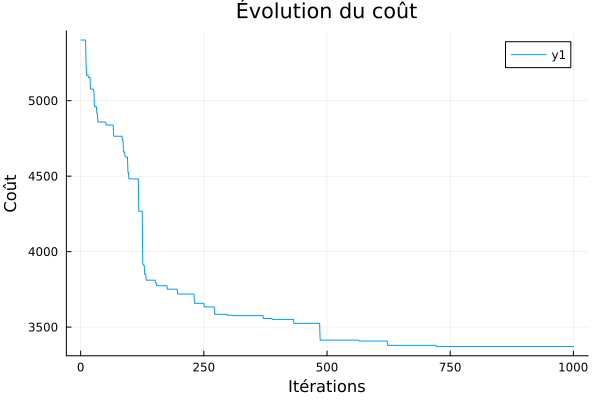

In [19]:
# Execution du programme

L, S, costs, cost_f = metaheuristique(wind_scenarios, general_parameters, sub_sub_cable_types, land_substation_cable_types, substation_types)

display(plot(1:1000, costs, xlabel="Itérations", ylabel="Coût", title="Évolution du coût"))



In [21]:
# Mise en forme des solutions a format JSON

# on crée un dictionnaire pour les sous-stations qui contient les informations suivantes :
# - id : identifiant de la sous-station
# - land_cable_type : type de câble entre la sous-station et la station terrestre
# - substation_type : type de sous-station

substations = Dict()
for i in 1:size(S, 1)
    if S[i, 3] != 0
        substations[i] = Dict("id" => i, "land_cable_type" => S[i, 3], "substation_type" => S[i, 5])
    end
end


# on crée un dictionnaire pour les câbles entre les sous-stations qui contient les informations suivantes :
# - substation_id : identifiant de la première sous-station
# - other_substation_id : identifiant de la deuxième sous-station
# - cable_type : type de câble entre les deux sous-stations

substation_substation_cables = Dict()
for i in 1:size(S, 1)
    if S[i, 2] != 0 && S[i, 4] != 0
        substation_substation_cables[i] = Dict("substation_id" => i, "other_substation_id" => S[i, 2], "cable_type" => S[i, 4])
        S[S[i, 2], 4] = 0
        S[S[i, 2], 2] = 0
    end
end


# on crée un dictionnaire pour les turbines qui contient les informations suivantes :
# - id : identifiant de la turbine
# - substation_id : identifiant de la sous-station à laquelle est reliée la turbine

turbines = Dict()
for i in 1:length(L)
    turbines[i] = Dict("id" => i, "substation_id" => L[i])
end

solutions = Dict("substations" => substations, "substation_substation_cables" => substation_substation_cables, "turbines" => turbines)

# on écrit le dictionnaire dans un fichier JSON

open("solution.json", "w") do f
    JSON.print(f, solutions)
end